In [56]:
import quadratic2SLS as q2sls
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Suppressing warnings
import warnings
warnings.filterwarnings(action = "ignore")

In [33]:
# DGP:
# Y = 1.5 + 1.2*X1 - 0.1*(X1)^2 + 3*X2 + 2*X3 + 4*X4 + epsilon
# model 1: X1 = 1 + 2*X3 + 2.5*X4 + 2*Z1 + eta
# model 2: X1 = 1 + 2*X3 + 2.5*X4 + 2*Z2 + eta
# model 3: X1 = 1 + 2*X3 + 2.5*X4 + 2*Z1 + 2*Z2 + eta
# We will leave out X4 from the estimation
# so X1 is the endogenous variable and Z is the instrument

n = 1500
n_bootstraps = 5000

X2 = np.random.binomial(1, 0.7, n)
X3 = np.random.normal(2, 1, n)
X4 = np.random.normal(1.5, 2, n)
Z1 = np.random.normal(2, 1, n)
Z2 = np.random.binomial(1, 0.4, n)
epsilon = np.random.normal(0, 1, n)
eta = np.random.normal(0, 1, n)

# Model 1:
X1_1 = 1 + 2*X3 + 2.5*X4 + 2*Z1 + eta
Y_1 = 1.5 + 1.2*X1_1 - 0.1*(X1_1)**2 + 3*X2 + 2*X3 + 4*X4 + epsilon

# Model 2:
X1_2 = 1 + 2*X3 + 2.5*X4 + 2*Z2 + eta
Y_2 = 1.5 + 1.2*X1_2 - 0.1*(X1_2)**2 + 3*X2 + 2*X3 + 4*X4 + epsilon

# Model 2:
X1_3 = 1 + 2*X3 + 2.5*X4 + 2*Z1 + 2*Z2 + eta
Y_3 = 1.5 + 1.2*X1_3 - 0.1*(X1_3)**2 + 3*X2 + 2*X3 + 4*X4 + epsilon

# Constructing the data sets
exogenous = pd.DataFrame({'X2' : X2, 'X3' : X3})
exogenous = sm.add_constant(exogenous)
endog1 = pd.DataFrame({'X1' : X1_1})
endog2 = pd.DataFrame({'X1' : X1_2})
endog3 = pd.DataFrame({'X1' : X1_3})
instruments1 = pd.DataFrame({'Z1' : Z1})
instruments2 = pd.DataFrame({'Z2' : Z2})
instruments3 = pd.DataFrame({'Z1' : Z1, 'Z2' : Z2})
Y_1 = pd.DataFrame({'Y' : Y_1})
Y_2 = pd.DataFrame({'Y' : Y_2})
Y_3 = pd.DataFrame({'Y' : Y_3})

## Estimating the models
# model 1:
model1 = q2sls.Quadratic2SLS(Y_1, exogenous, endog1, instruments1)
result1 = model1.fit(cov_type='Bootstrap', n_iter = n_bootstraps)

# model 2:
model2 = q2sls.Quadratic2SLS(Y_2, exogenous, endog2, instruments2)
result2 = model2.fit(cov_type='Bootstrap', n_iter = n_bootstraps)

# model 3:
model3 = q2sls.Quadratic2SLS(Y_3, exogenous, endog3, instruments3)
result3 = model3.fit(cov_type='Bootstrap', n_iter = n_bootstraps)

100%|██████████| 5000/5000 [00:57<00:00, 87.51it/s]


In [45]:
coeff_estms1 = pd.DataFrame([result1.beta_hat_boots.mean(axis=0), result1.result2.params]).transpose()
coeff_estms1.columns = ['Bootstrapped', 'Full_Sample']
coeff_estms1['True_Coeffs'] = [1.5, 1.2, -0.1, 3, 2]
coeff_estms1

,Bootstrapped,Full_Sample,True_Coeffs
const,746.502873,-14.724628,1.5
endog_hat,-152.498194,5.854600,1.2
endog_sq_hat,6.209220,-0.285066,-0.1
X2,30.190102,2.411251,3.0
X3,-10.649633,1.625686,2.0


/Users/nadavtadelis/anaconda/envs/study_env/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


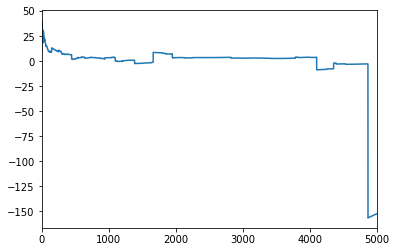

In [35]:
import seaborn as sns
cumsum_beta_hat_boots = np.cumsum(result1.beta_hat_boots['endog_hat'])
sns.tsplot(cumsum_beta_hat_boots/np.arange(n_bootstraps));

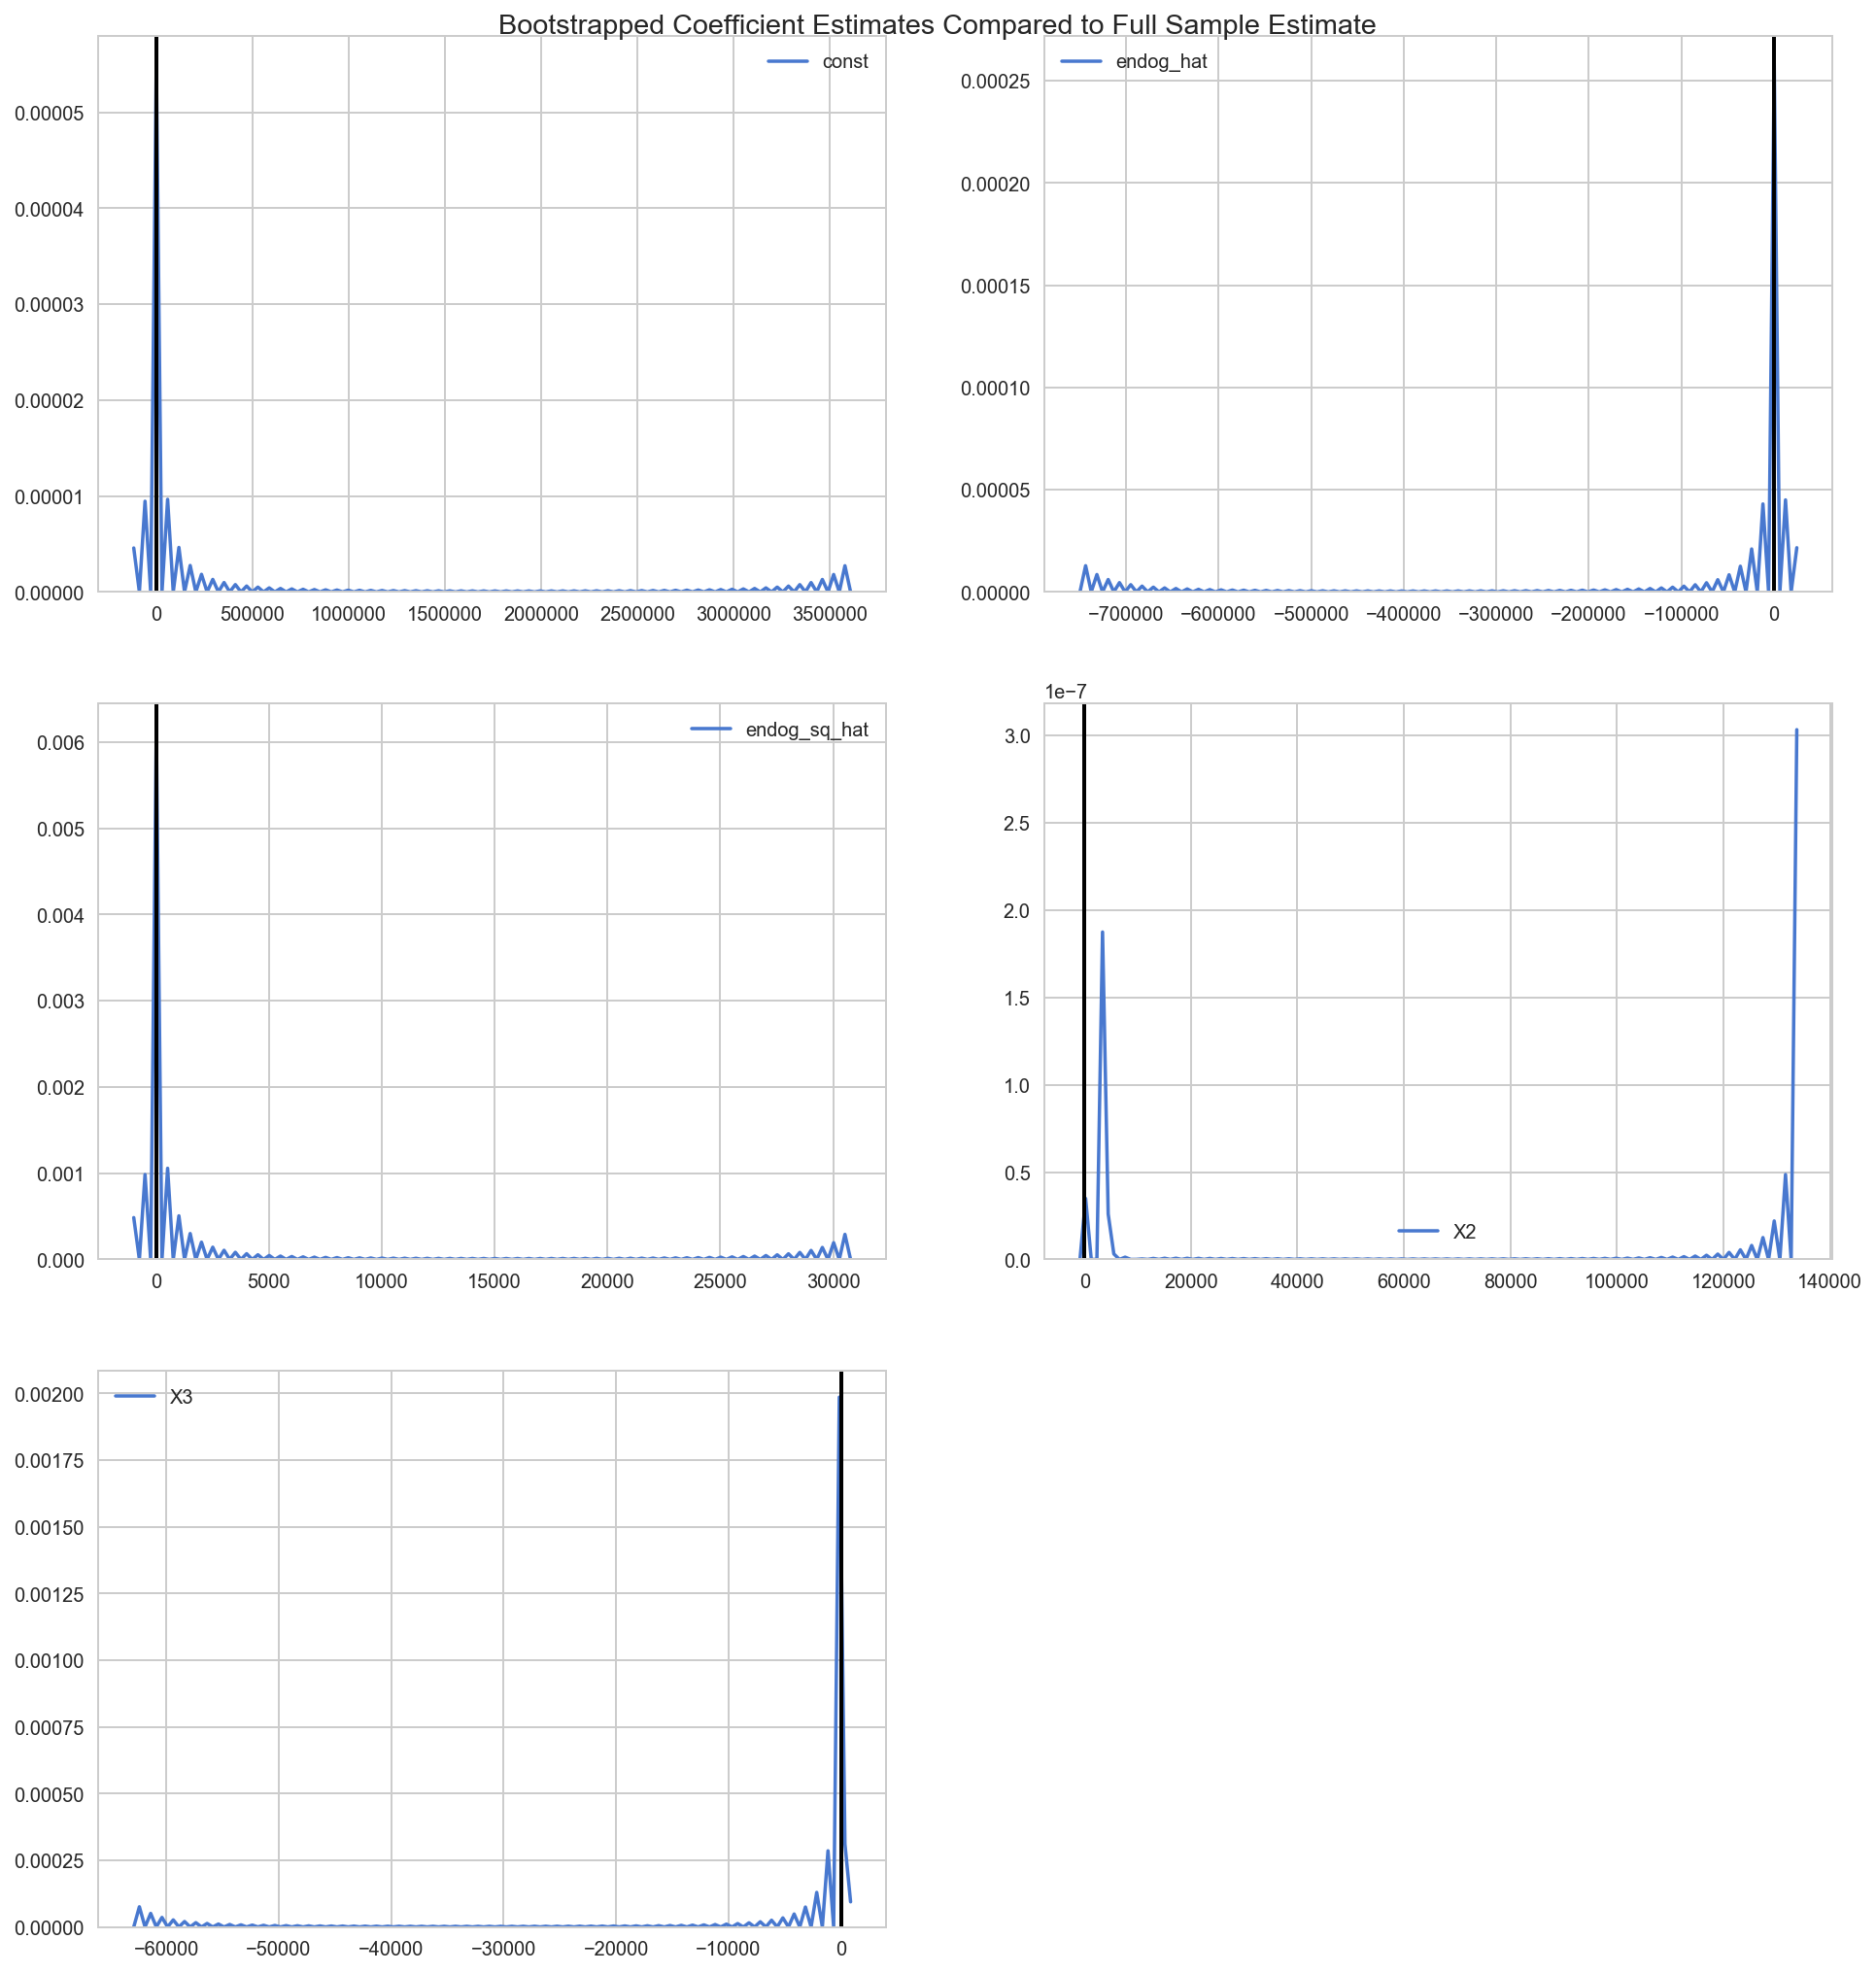

In [52]:
# Creating distribution plots
# Plotting preferences
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
plt.figure(figsize=(16, 16))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.97)
plt.suptitle('Bootstrapped Coefficient Estimates Compared to Full Sample Estimate')

sns.despine()
for column_index, column in enumerate(result1.X_hat.columns.values.tolist()):
    plt.subplot(3, 2, column_index + 1)
    sns.kdeplot(result1.beta_hat_boots[column])
    plt.plot([result1.result2.params[column_index], result1.result2.params[column_index]], 
             [0, 1], 
             linewidth=2,
            color = 'red')
    plt.plot([coeff_estms1['True_Coeffs'][column_index], coeff_estms1['True_Coeffs'][column_index]], 
             [0, 1], 
             linewidth=2,
            color = 'black')

In [44]:
coeff_estms3 = pd.DataFrame([result3.beta_hat_boots.mean(axis=0), result3.result2.params]).transpose()
coeff_estms3.columns = ['Bootstrapped', 'Full_Sample']
coeff_estms3['True_Coeffs'] = [1.5, 1.2, -0.1, 3, 2]
coeff_estms3

,Bootstrapped,Full_Sample,True_Coeffs
const,-2.617865,1.589438,1.5
endog_hat,3.271453,2.454104,1.2
endog_sq_hat,-0.178708,-0.146940,-0.1
X2,2.486843,2.491079,3.0
X3,1.702747,1.712935,2.0


/Users/nadavtadelis/anaconda/envs/study_env/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


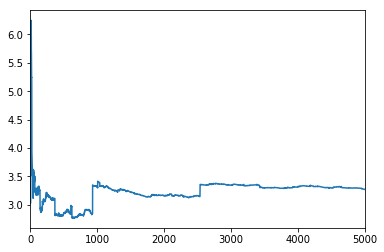

In [39]:
cumsum_beta_hat_boots = np.cumsum(result3.beta_hat_boots['endog_hat'])
sns.tsplot(cumsum_beta_hat_boots/np.arange(n_bootstraps));

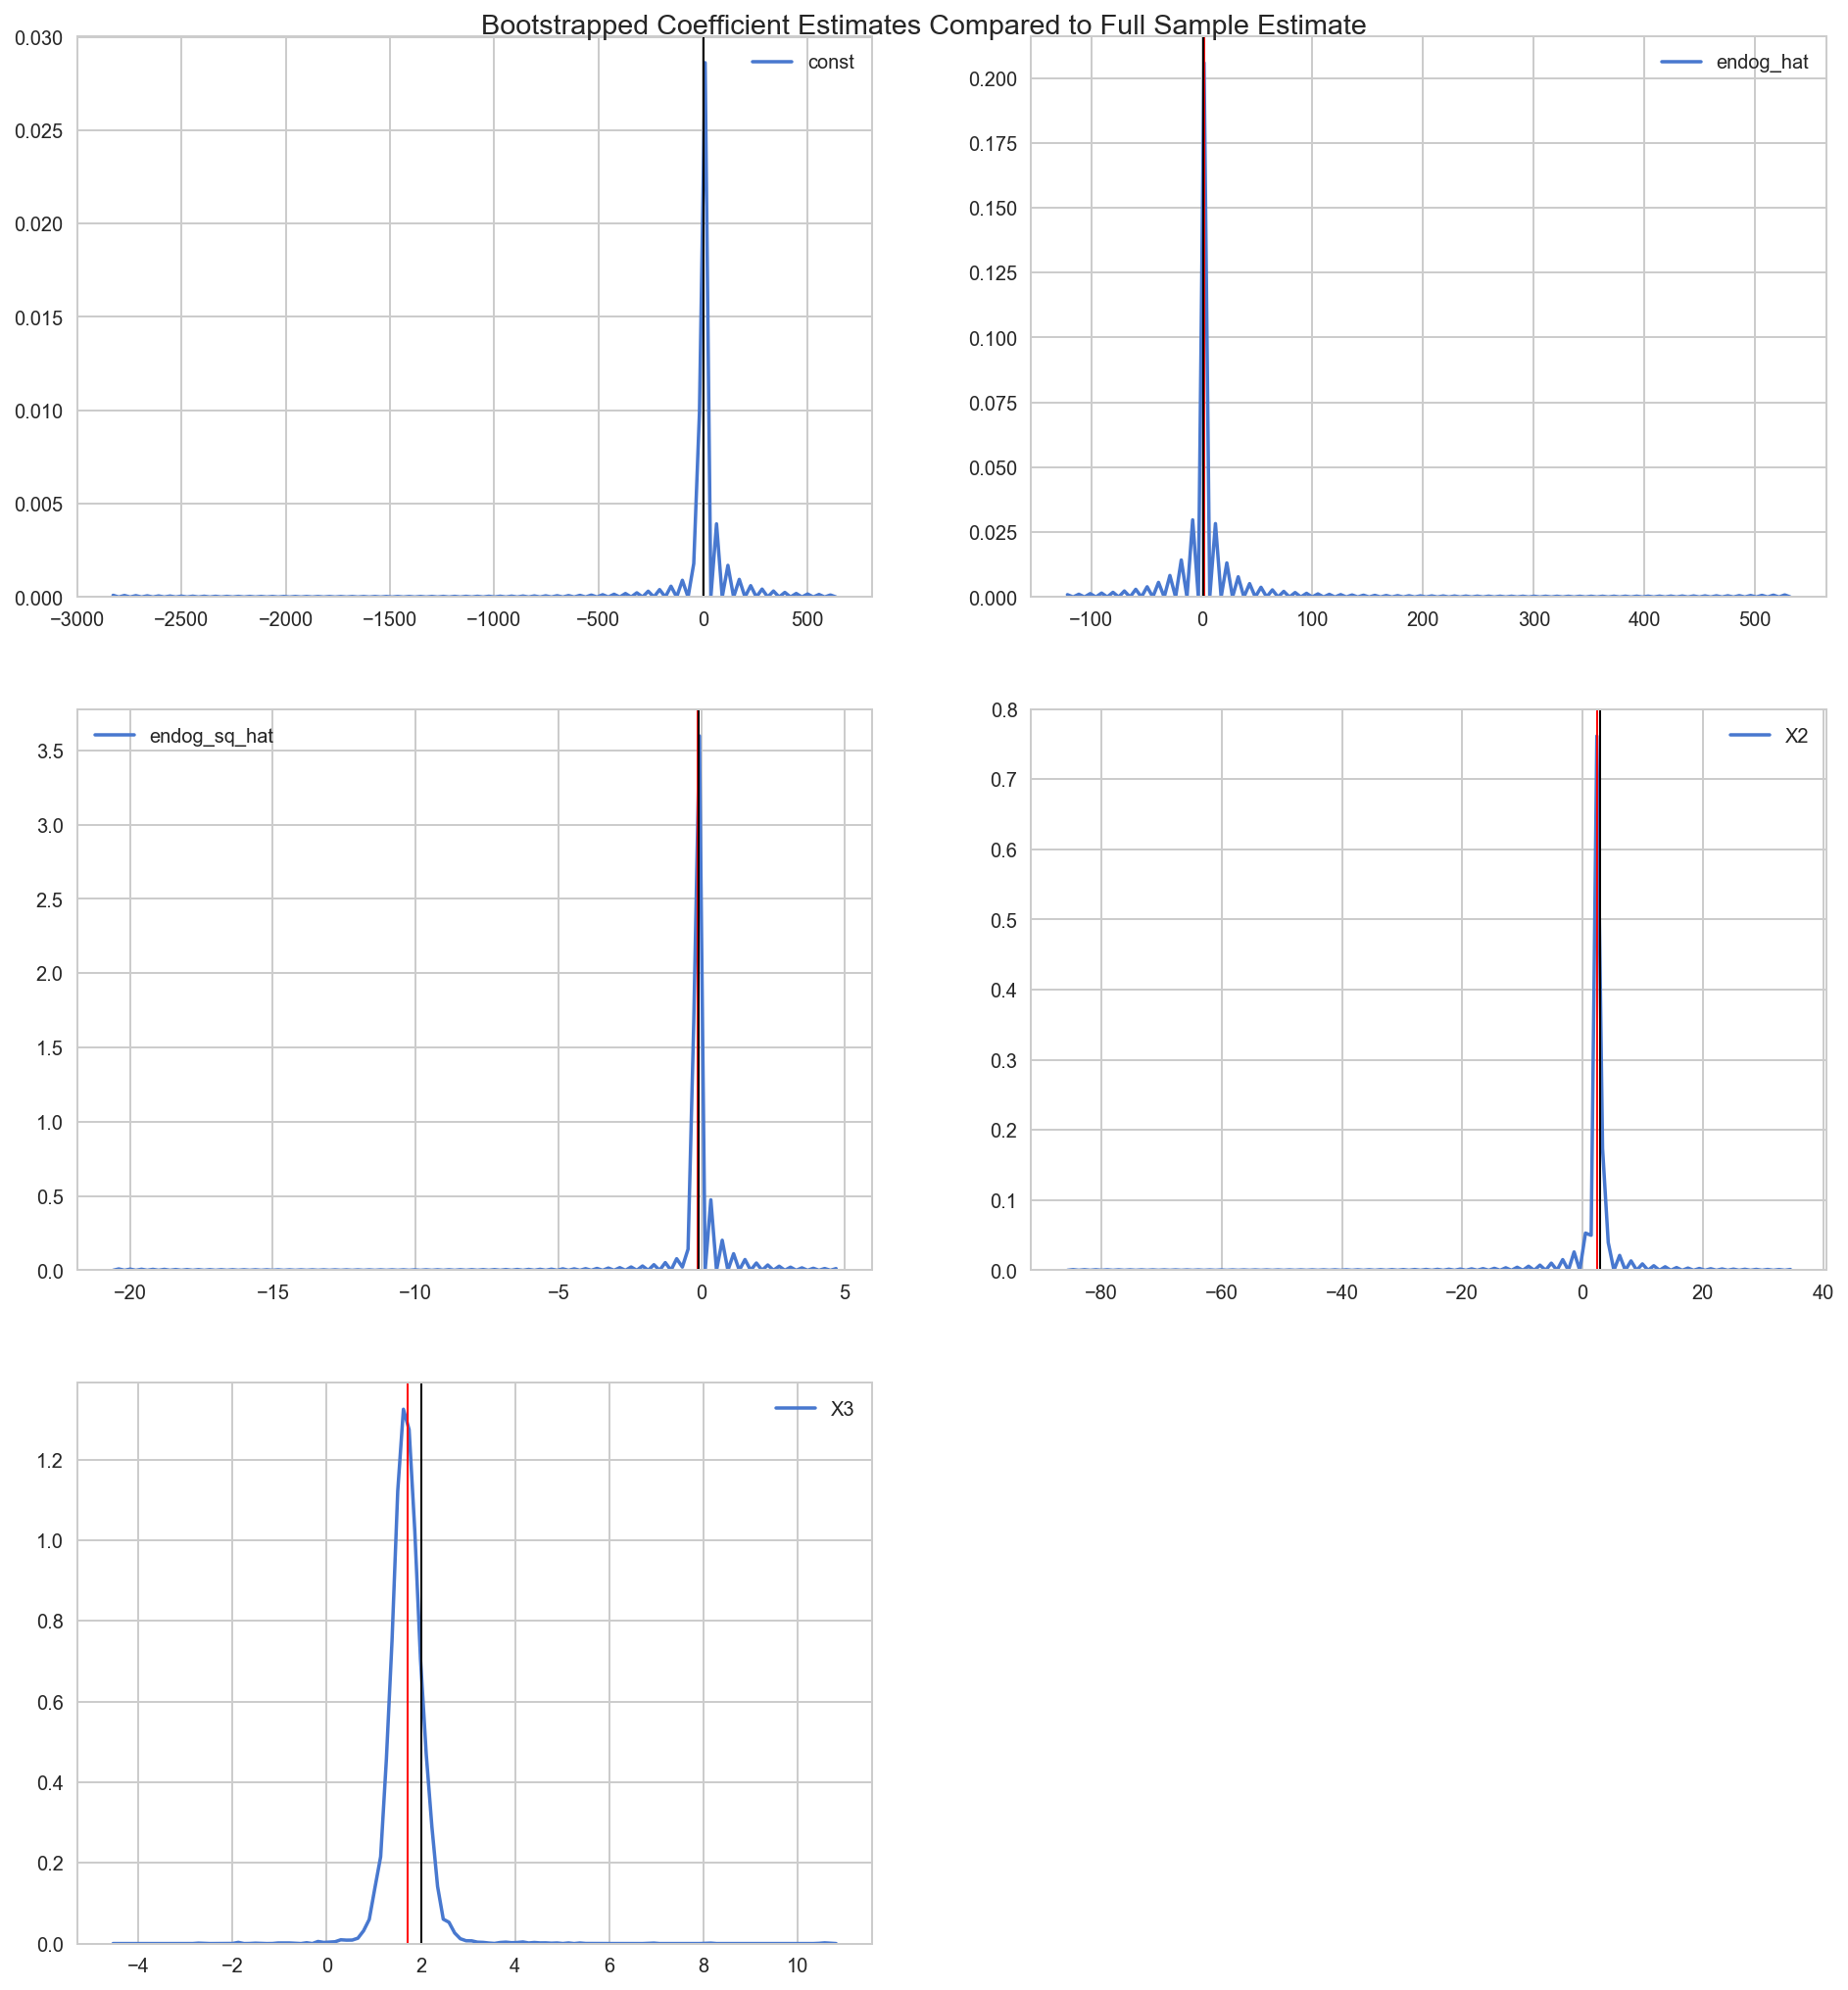

In [55]:
plt.figure(figsize=(16, 16))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.97)
plt.suptitle('Bootstrapped Coefficient Estimates Compared to Full Sample Estimate')

sns.despine()
for column_index, column in enumerate(result3.X_hat.columns.values.tolist()):
    plt.subplot(3, 2, column_index + 1)
    sns.kdeplot(result3.beta_hat_boots[column])
    plt.plot([result3.result2.params[column_index], result3.result2.params[column_index]], 
             [0, 5], 
             linewidth=1,
            color = 'red')
    plt.plot([coeff_estms1['True_Coeffs'][column_index], coeff_estms1['True_Coeffs'][column_index]], 
             [0, 5], 
             linewidth=1,
            color = 'black')

In [65]:
np.random.seed(1234)
n = 1500
n_bootstraps = 10000

X2 = np.random.binomial(1, 0.7, n)
X3 = np.random.normal(2, 1, n)
X5 = np.random.normal(1, 0.5, n)
X4 = np.random.normal(1.5, 2, n)
Z1 = np.random.normal(2, 1, n)
Z2 = np.random.binomial(1, 0.4, n)
Z3 = np.random.normal(1, 0.75, n)
Z4 = np.random.binomial(1, 0.6, n)
epsilon = np.random.normal(0, 1, n)
eta = np.random.normal(0, 1, n)

# Model 1:
X1 = 1 + 2*X3 - 3*X4 + 2*Z1 + 2*Z2 - Z3 + 3*Z4 + eta
Y = 0.7 + 1.2*X1 - 0.1*(X1)**2 + 0.3*X2 + 0.2*X3 + 0.4*X4 + 0.3*X5 + epsilon

# Constructing the data sets
exogenous = pd.DataFrame({'X2' : X2, 'X3' : X3, 'X5' : X5})
exogenous = sm.add_constant(exogenous)
endog1 = pd.DataFrame({'X1' : X1_1})
instruments3 = pd.DataFrame({'Z1' : Z1, 'Z2' : Z2, 'Z3' : Z3, 'Z4' : Z4})
Y = pd.DataFrame({'Y' : Y})

## Estimating the models
# model 1:
model = q2sls.Quadratic2SLS(Y_1, exogenous, endog1, instruments1)
result = model.fit(cov_type='Bootstrap', n_iter = n_bootstraps)

coeff_estms = pd.DataFrame([result.beta_hat_boots.mean(axis=0), result.result2.params]).transpose()
coeff_estms.columns = ['Bootstrapped', 'Full_Sample']
coeff_estms['True_Coeffs'] = [0.7, 1.2, -0.1, 0.3, 0.2, 0.3]
coeff_estms

100%|██████████| 10000/10000 [02:00<00:00, 82.66it/s]


,Bootstrapped,Full_Sample,True_Coeffs
const,92.666878,-0.926162,0.7
endog_hat,-14.973217,4.257456,1.2
endog_sq_hat,0.539845,-0.221683,-0.1
X2,-0.225183,-0.078597,0.3
X3,0.392826,-0.123528,0.2
X5,2.713016,-0.546400,0.3


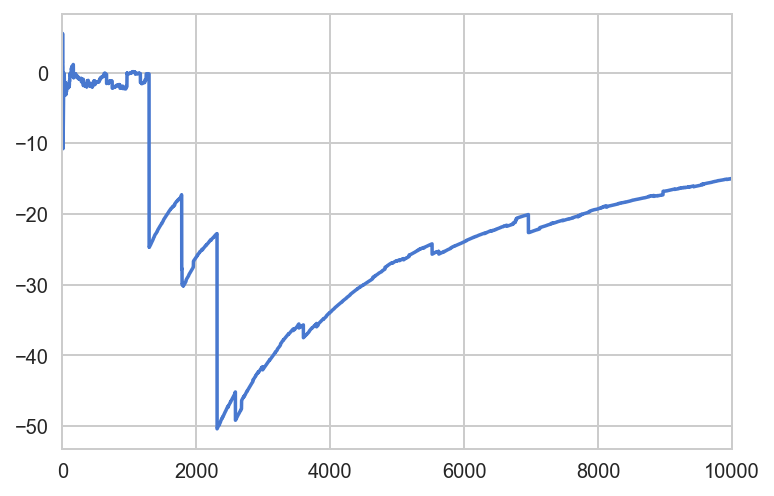

In [68]:
cumsum_beta_hat_boots = np.cumsum(result.beta_hat_boots['endog_hat'])
plt.suptitle
sns.tsplot(cumsum_beta_hat_boots/np.arange(n_bootstraps));

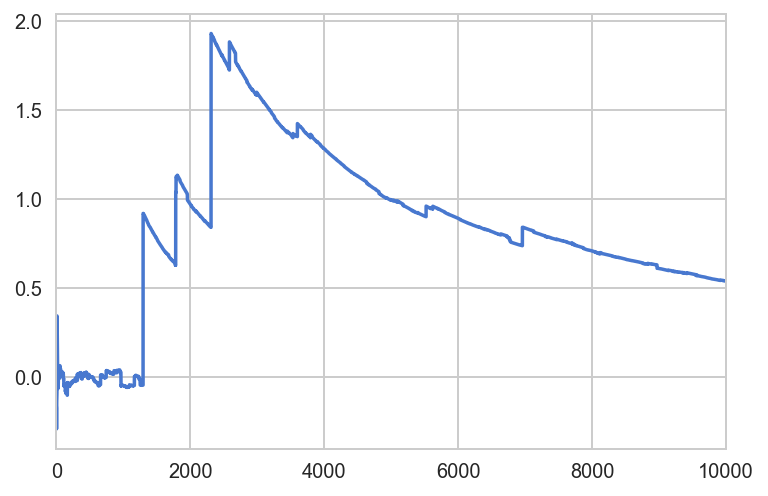

In [71]:
cumsum_beta_hat_boots = np.cumsum(result.beta_hat_boots['endog_sq_hat'])
plt.suptitle
sns.tsplot(cumsum_beta_hat_boots/np.arange(n_bootstraps));

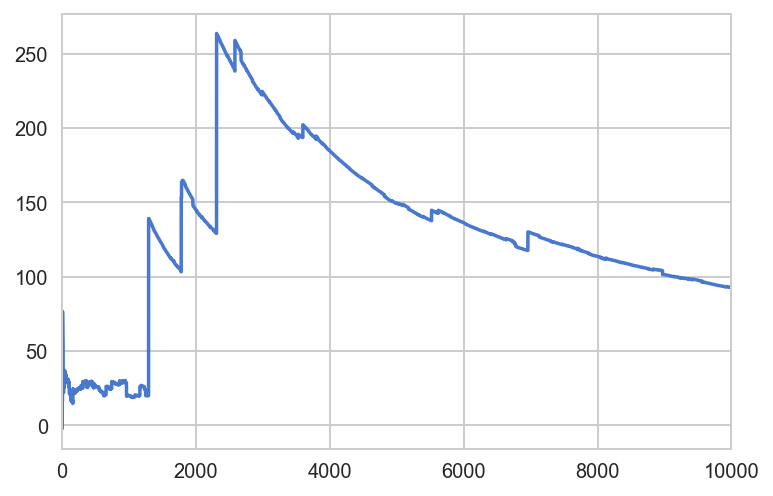

In [72]:
cumsum_beta_hat_boots = np.cumsum(result.beta_hat_boots['const'])
plt.suptitle
sns.tsplot(cumsum_beta_hat_boots/np.arange(n_bootstraps));

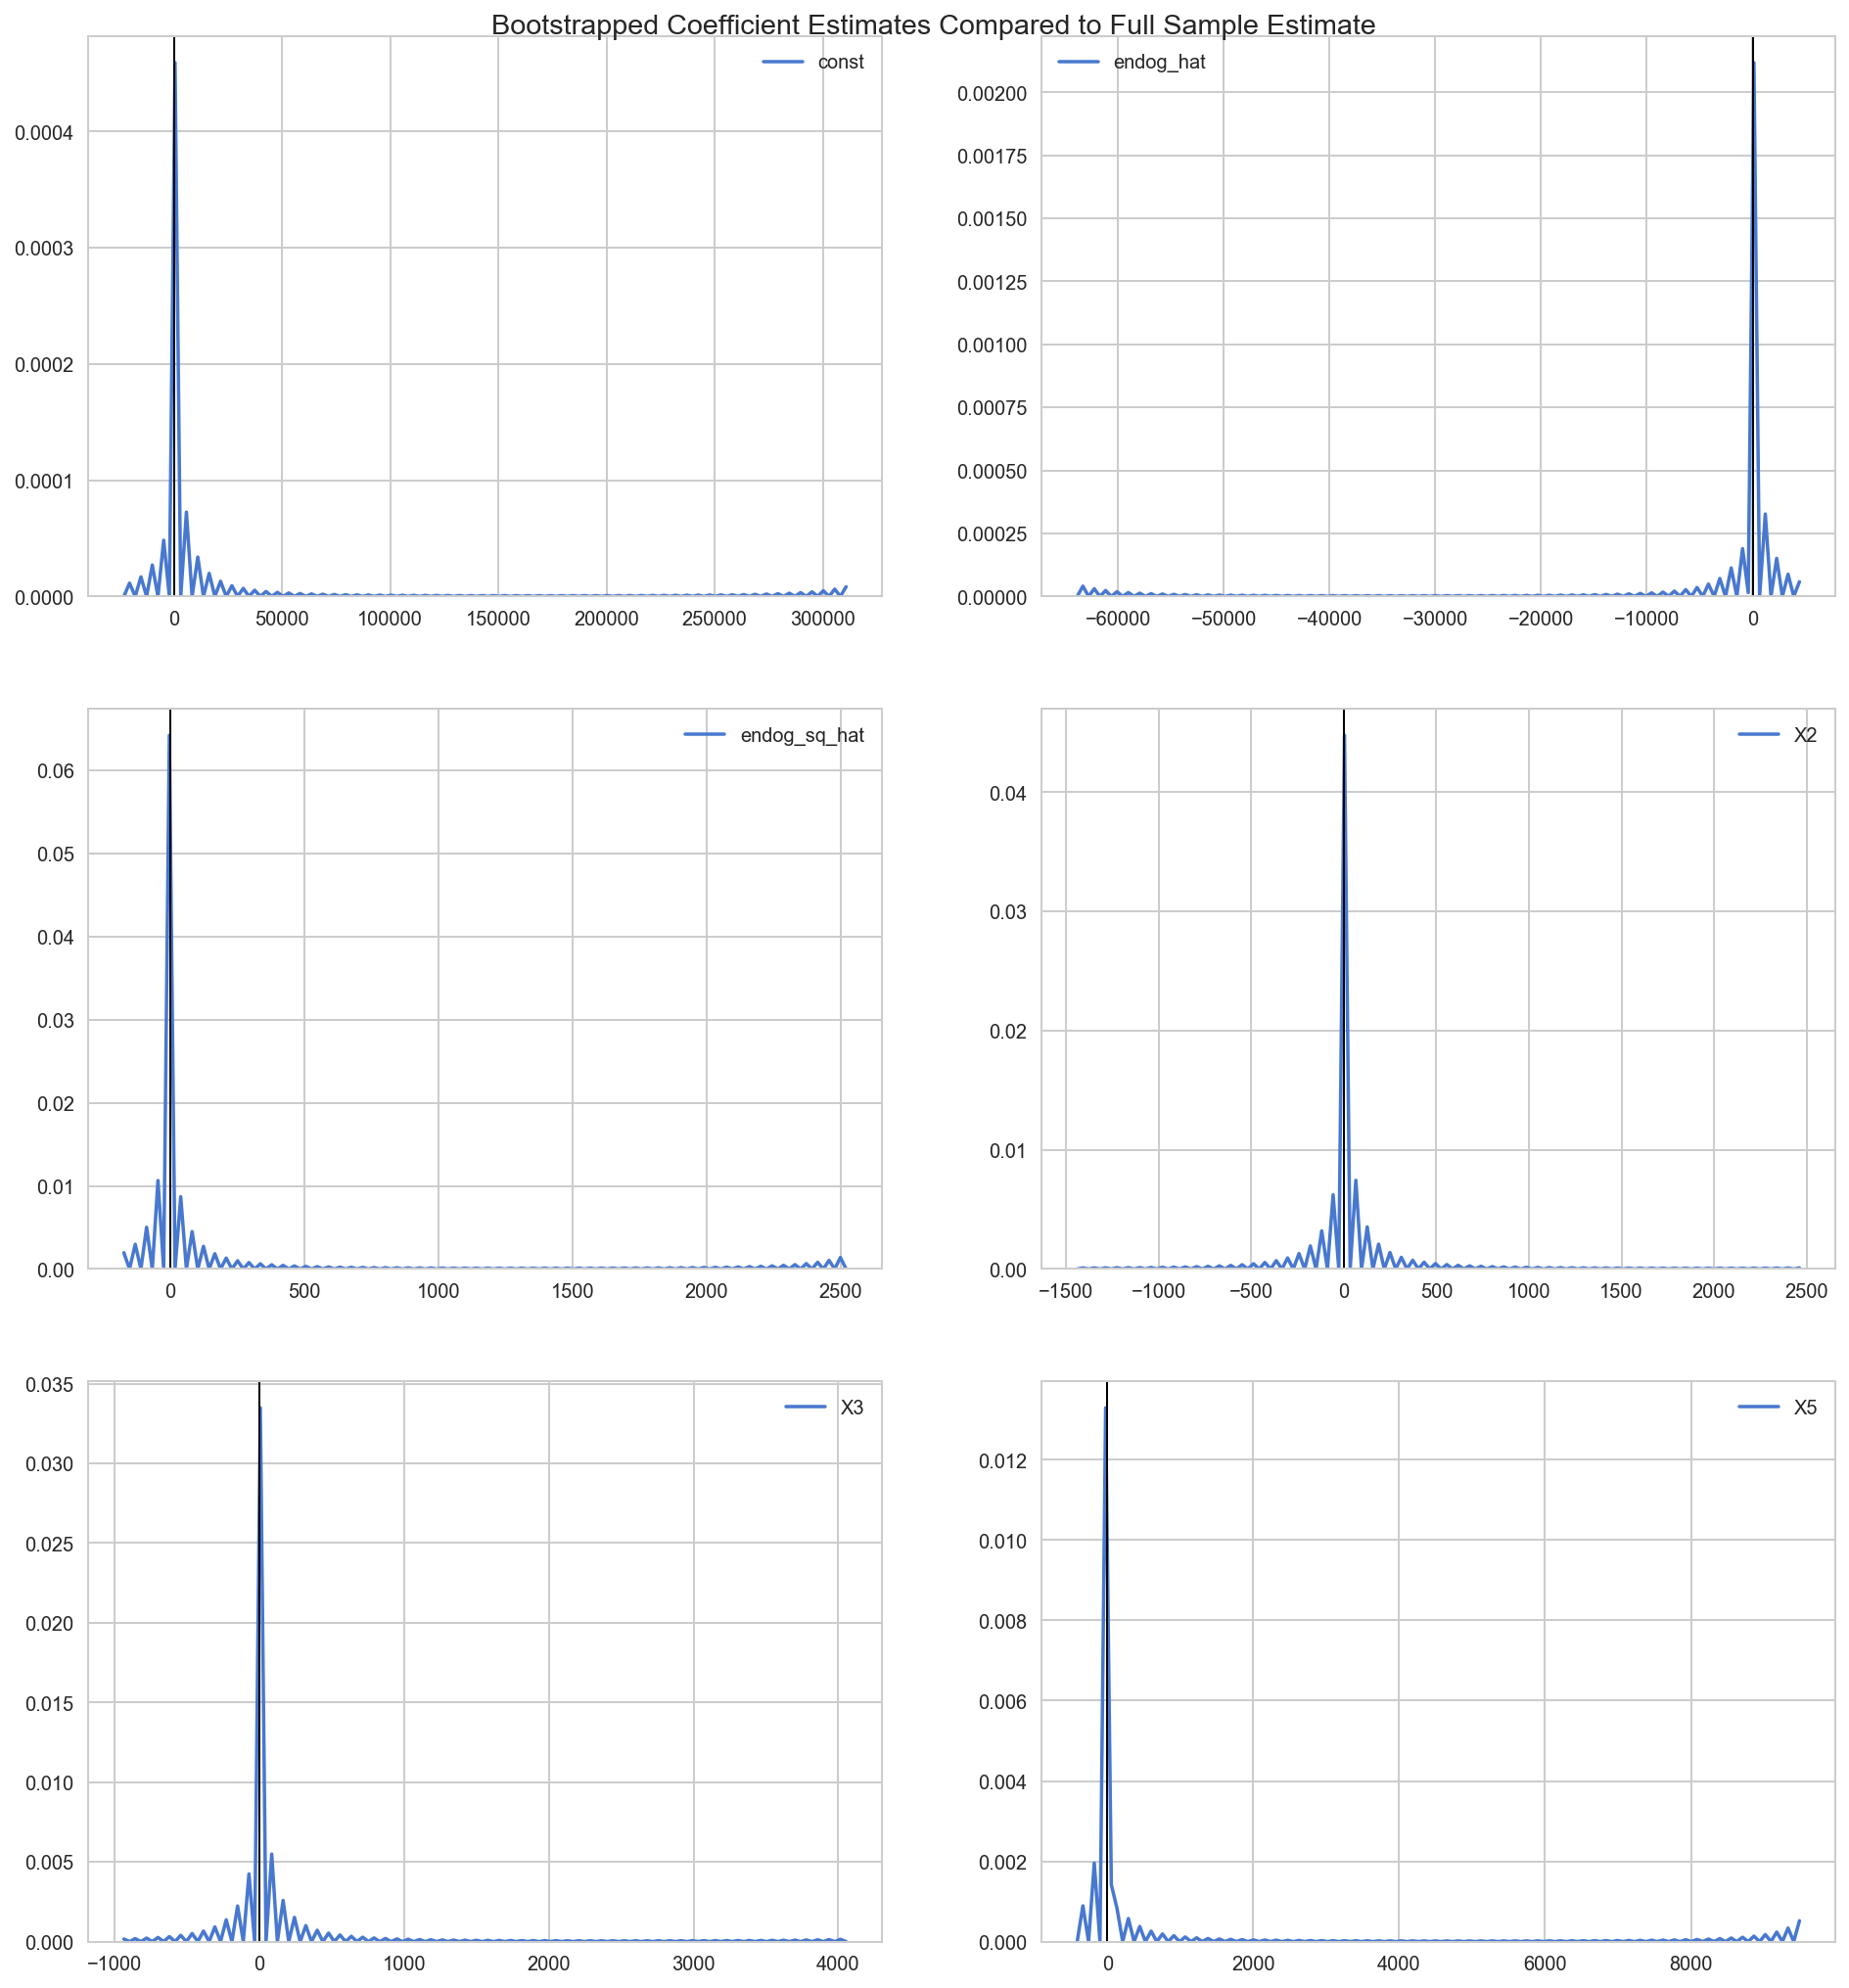

In [67]:
plt.figure(figsize=(16, 16))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.97)
plt.suptitle('Bootstrapped Coefficient Estimates Compared to Full Sample Estimate')

sns.despine()
for column_index, column in enumerate(result.X_hat.columns.values.tolist()):
    plt.subplot(3, 2, column_index + 1)
    sns.kdeplot(result.beta_hat_boots[column])
    plt.plot([result.result2.params[column_index], result.result2.params[column_index]], 
             [0, 5], 
             linewidth=1,
            color = 'red')
    plt.plot([coeff_estms['True_Coeffs'][column_index], coeff_estms['True_Coeffs'][column_index]], 
             [0, 5], 
             linewidth=1,
            color = 'black')